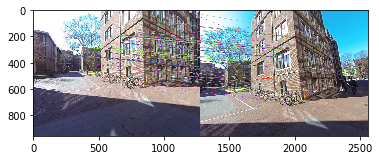

In [9]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from tqdm import tqdm
import time
import cv2
import torch.nn as nn
import torch

#img1 = cv2.imread('donald-trump-1.jpg')
#img2 = cv2.imread('donald-trump-2.jpg')

#data  cis.upenn.edu/~cis580/Spring2015/Projects/proj2/SfMProjectData.zip

img1 = cv2.imread('image0000001.bmp')
img2 = cv2.imread('image0000002.bmp')
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
#Oriented FAST and Rotated BRIEF
orb = cv2.ORB_create(edgeThreshold=3)

# find the keypoints with ORB
kp1, des1 = orb.detectAndCompute(img1,None)
kp2, des2 = orb.detectAndCompute(img2,None)

# create BFMatcher object
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

# Match descriptors.
matches = bf.match(des1,des2)

# Sort them in the order of their distance.
matches = sorted(matches, key = lambda x:x.distance)

# Draw first 10 matches.
img3 = cv2.drawMatches(img1, kp1, img2, kp2, matches[:100], None, flags=2)

plt.imshow(img3)
plt.show()

In [10]:
pts1 = cv2.KeyPoint_convert(kp1)
pts2 = cv2.KeyPoint_convert(kp2)
print(dir(matches[0]))
print(matches[0].trainIdx)
print(matches[0].queryIdx)

['__class__', '__delattr__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', 'distance', 'imgIdx', 'queryIdx', 'trainIdx']
427
339


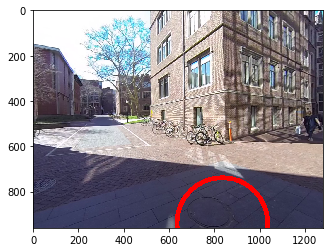

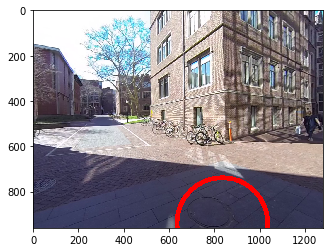

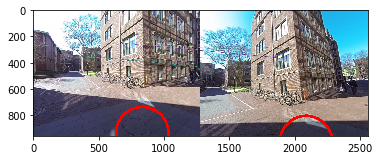

[[520.059  291.1335]]
[[634.52167 443.75046]]


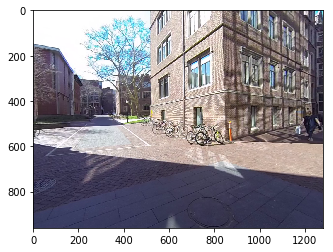

In [11]:
imageA = img1.copy()
imageB = img2.copy()
imageA = cv2.circle(imageA , (835, 938), 200, (255, 0, 0), 20)
plt.imshow(imageA)
plt.show()
imageB = cv2.circle(imageB , (806, 1006), 200, (255, 0, 0), 20)
plt.imshow(imageA)
plt.show()
img4 = cv2.drawMatches(imageA, kp1, imageB, kp2, matches[:10], None, flags=2)
plt.imshow(img4)
plt.show()
print(cv2.KeyPoint_convert([kp1[matches[0].trainIdx]]))
print(cv2.KeyPoint_convert([kp2[matches[0].queryIdx]]))

plt.imshow(img1)
plt.show()

In [16]:
import random
import scipy.linalg

#Normalized 8-point algorithm

class LinearLeastSquaresModel():
    """linear system solved using linear least squares

    This class serves as an example that fulfills the model interface
    needed by the ransac() function.

    """

    def __init__(self, device = 'cuda' if torch.cuda.is_available() else 'cpu'):
        self.device = device    
        self.MSE = nn.MSELoss(reduction='none')
        #value will be assigned after calling fit
        self.x = None
        
    def fit(self, data, T1, T2):
        _, _, Vh = scipy.linalg.svd(data)
        #(Hermitian) transpose back
        x = Vh.transpose()[:, -1];
        U, D, Vh = scipy.linalg.svd(x.reshape((3, 3)).transpose())
        F = U @ np.diag(np.array([D[0], D[1], 0])) @ Vh
        F = T2.transpose() @ F @ T1
        self.x = torch.tensor(F).view(9).to(self.device);
        return F
    
    def calc_err(self, data):
        batch_size = data.shape[0]
        compute_result = (data @ self.x)
        err = self.MSE(compute_result, torch.zeros((batch_size), dtype=torch.float64).to(self.device))
        return err

def EstimateFundamentalMatrix(sample_points, T1, T2, device = 'cuda' if torch.cuda.is_available() else 'cpu'):
    LSmodel = LinearLeastSquaresModel(device = device)
    F = LSmodel.fit(np.array(sample_points), T1, T2)
 
    return F, LSmodel    
    


def convert2Homogeneous(a):
    temp = np.zeros((3,len(a)))
    for i in range(len(a)):
        x1 = a[i][0]
        y1 = a[i][1]
        temp[0][i] = x1
        temp[1][i] = y1
        temp[2][i] = 1
    return temp

def normalise2dpts(pts):
    """
    based on http://pydoc.net/ippe/0.0.1/ippe.homo2d/
    Function translates and normalises a set of 2D homogeneous points 
    so that their centroid is at the origin and their mean distance from 
    the origin is sqrt(2).  This process typically improves the
    conditioning of any equations used to solve homographies, fundamental
    matrices etc.
       
       
    Inputs:
    pts: 3xN array of 2D homogeneous coordinates
   
    Returns:
    newpts: 3xN array of transformed 2D homogeneous coordinates.  The
            scaling parameter is normalised to 1 unless the point is at
            infinity. 
    T: The 3x3 transformation matrix, newpts = T*pts
    """
    if pts.shape[0] != 3:
        print("Input shoud be 3")

    finiteind = np.nonzero(abs(pts[2,:]) > np.spacing(1));
    
    if len(finiteind) != pts.shape[1]:
        print('WARNING(normalise2dpts): Some points are at infinity')
    
    dist = []
    for i in finiteind:
        pts[0,i] = pts[0,i]/pts[2,i]
        pts[1,i] = pts[1,i]/pts[2,i]
        pts[2,i] = 1;

        c = np.mean(pts[0:2,i].T, axis=0).T          

        newp1 = pts[0,i]-c[0]
        newp2 = pts[1,i]-c[1]
    
        dist.append(np.sqrt(newp1**2 + newp2**2))

    meandist = np.mean(dist[:])
    
    scale = np.sqrt(2)/meandist
    
    T = np.array([[scale, 0, -scale*c[0]], [0, scale, -scale*c[1]], [0, 0, 1]])
    
    newpts = T.dot(pts)
    return [newpts, T]

def transform(a,b):
    #####
    #input shape: [batch, [x, y, 1]]
    #return: list 
    #        shape: [batch, [x1*x2, x1*y2, x1, y1*x2, y1*y2, y1, x2, y2, 1]]
    #####
    mat = []
    assert(len(a)==len(b))
    for i in range(len(a)):
        x1 = a[i][0]
        y1 = a[i][1]
        x2 = b[i][0]
        y2 = b[i][1]
        mat.append([x1*x2, x1*y2, x1, y1*x2, y1*y2, y1, x2, y2, 1])
    return mat

    
def RANSAC(trainPoints, queryPoints, max_iter_times = 1000, device = 'cuda' if torch.cuda.is_available() else 'cpu'):
    
    t = time.time()
    x1, T1 = normalise2dpts(convert2Homogeneous(trainPoints))
    x2, T2 = normalise2dpts(convert2Homogeneous(queryPoints))
    data = transform(x1.transpose(), x2.transpose())
    
    iterations = 0
    batches = torch.tensor(data, dtype=torch.float64).to(device)
    
    batch_size = batches.shape[0]
    
    episilon = batches.new_full((1, batch_size), 0.01).view(batch_size).to(device)
    #best = 10000000
    train_inliers = []
    query_inliers = []
    
    while iterations < max_iter_times:

        sample_points = random.sample(data, 8)
        F, LSmodel = EstimateFundamentalMatrix(sample_points, T1, T2, device)
        err = LSmodel.calc_err(batches)
        if((err < episilon).float().mean().item() > 0.95):   
        #if(err.sum().item() < best):
            ind = np.where((err.cpu()<episilon.cpu()))
            train_inliers = trainPoints[ind]
            query_inliers = queryPoints[ind]
            #best = err.sum().item()
            break
        iterations += 1
    #print(sample_points)
    #print(train_inliers[0])
    F, _ = EstimateFundamentalMatrix(transform(train_inliers,query_inliers), T1, T2, device)    
    print('[RANSAC] takes ', time.time() - t,'sec')
    print('[RANSAC] iteration', iterations,' err:', err.mean().item())     
    if(iterations == max_iter_times):
        print("no result found by RANSAC")
    
    return F, train_inliers, query_inliers, ind

In [17]:
trainPoints = cv2.KeyPoint_convert([kp1[matches[i].trainIdx] for i in range(len(matches))])
queryPoints = cv2.KeyPoint_convert([kp2[matches[i].queryIdx] for i in range(len(matches))])
F, train_inliers, query_inliers, ind = RANSAC(trainPoints, queryPoints, max_iter_times = 1000)
print('F',F)
F, mask = cv2.findFundamentalMat(trainPoints,queryPoints,cv2.FM_LMEDS)
print('opencv_F',F)

WARNING(normalise2dpts): Some points are at infinity
WARNING(normalise2dpts): Some points are at infinity
[[-1.1685269683686599, -0.03897627913925862, -0.6992428096382723, -0.864406805244352, -0.02883233493371058, -0.5172582743326222, 1.6711319047716122, 0.055740693507340566, 1], [1.886731084621284, -1.5411369150843313, -2.0023696918181058, -0.28901772092644845, 0.23607809425724152, 0.30673174863053054, -0.9422491222927847, 0.76965653314749, 1], [-0.24186747745260245, -0.24738323968684148, 0.45482084741809947, -0.5854659709844967, -0.5988174605117366, 1.100942267485347, -0.5317862600749761, -0.5439135894741243, 1], [-0.17872999358637362, 1.6726764424714589, 1.759374602683223, -0.08118513078171913, 0.7597854899039128, 0.7991666890753044, -0.1015872306635508, 0.9507221713445557, 1], [-0.23465054355825987, -0.016054446132488243, 0.08941932624992655, 2.5024822927120245, 0.17121616918767477, -0.9536320571578911, -2.6241591543914438, -0.17954112165435188, 1], [0.141384816609019, 0.6359322449

In [18]:
print(np.array(train_inliers).shape)


(178, 2)


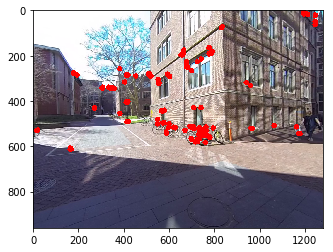

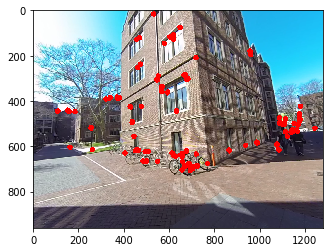

In [19]:
imageA = img1.copy()
imageB = img2.copy()
for i in train_inliers:
    imageA = cv2.circle(imageA , (int(i[0]), int(i[1])), 2, (255, 0, 0), 20)
plt.imshow(imageA)
plt.show()
for i in query_inliers:
    imageB = cv2.circle(imageB , (int(i[0]), int(i[1])), 2, (255, 0, 0), 20)
plt.imshow(imageB)
plt.show()


In [20]:
f1 = 568.996140852
f2 = 568.988362396
s = 0
mx = my = 1
px = 643.21055941
py = 477.982801038
K = np.array([[f1*mx, s, px],[0, f2*my, py], [0, 0, 1]])
E = K.transpose() @ F @ K

In [9]:
print('Fundamental Matrix:',F)
print('Camera intrinsic Matrix:',K)
print('Essential Matrix:',E)

Fundamental Matrix: [[ 7.52800151e-07 -1.17204131e-07 -3.29701499e-04]
 [ 1.76995033e-07  2.76222287e-06 -1.22144693e-03]
 [-8.18334512e-04 -1.43729919e-03  1.00000000e+00]]
Camera intrinsic Matrix: [[568.99614085   0.         643.21055941]
 [  0.         568.9883624  477.98280104]
 [  0.           0.           1.        ]]
Essential Matrix: [[ 0.24372402 -0.03794509  0.05603812]
 [ 0.05730253  0.89426346  0.12101994]
 [-0.14197872 -0.1094683  -0.04835481]]


In [10]:
U, D, Vh = scipy.linalg.svd(E)
print('U:',U)
print('D:',D)
print('Vh:',Vh)
W = np.array([[0, -1, 0],[1, 0 ,0], [0, 0, 1]])
print('W',W)
eps = 1e-5
def CameraPosition1Config():
    R1 = U @ W @ Vh
    C1 = U[:,2]
    det = np.linalg.det(R1)
    if det != 1:
        assert(abs(det) <= 1 + eps)
        C1 = -C1
        R1 = -R1 
    return C1, R1

def CameraPosition2Config():
    R2 = U @ W @ Vh
    C2 = -U[:,2]
    det = np.linalg.det(R2)
    if det != 1:
        assert(abs(det) <= 1 + eps)
        C2 = -C2
        R2 = -R2    
    return C2, R2

def CameraPosition3Config():
    R3 = U @ W.transpose() @ Vh
    C3 = U[:,2]
    det = np.linalg.det(R3)
    if det != 1:
        assert(abs(det) <= 1 + eps)
        C3 = -C3
        R3 = -R3
    return C3, R3    
        
def CameraPosition4Config():
    R4 = U @ W.transpose() @ Vh
    C4 = -U[:,2]
    det = np.linalg.det(R4)
    if det != 1:
        assert(abs(det) <= 1 + eps)
        C4 = -C4
        R4 = -R4
    return C4, R4

U: [[-0.0110137  -0.87889328  0.4768913 ]
 [ 0.99033886  0.05634136  0.12670673]
 [-0.1382304   0.47367949  0.86978164]]
D: [9.12907122e-01 2.87572730e-01 5.51831890e-09]
Vh: [[ 0.08072058  0.98714709  0.13793042]
 [-0.96751632  0.11086177 -0.22720439]
 [-0.23957536 -0.11510987  0.96402975]]
W [[ 0 -1  0]
 [ 1  0  0]
 [ 0  0  1]]


In [11]:
def CameraPoseMatrix(K, R, C):
    return K @ R @ np.array([[1,0,0, -C[0]],[0,1,0, -C[1]],[0,0,1, -C[2]]])

In [12]:
#first camera
C0 = np.array([0,0,0])
R0 = np.array([[1,0,0],[0,1,0],[0,0,1]])
P1 = CameraPoseMatrix(K, R0, C0)#K @ R0 @ np.array([[1,0,0,0],[0,1,0,0],[0,0,1,0]])


#second camera
C1, R1 = CameraPosition1Config()
C2, R2 = CameraPosition2Config()
C3, R3 = CameraPosition3Config()
C4, R4 = CameraPosition4Config()
E = U @ np.array([[1,0,0],[0,1,0],[0,0,0]]) @ Vh
P2 = CameraPoseMatrix(K, R1, C1) #np.concatenate((R1, -C1.reshape(3,1)), axis=1)
print('P1:', P1)
print('P2:', P2)
print('R1:', R1)
print('C1:', C1)

P1: [[568.99614085   0.         643.21055941   0.        ]
 [  0.         568.9883624  477.98280104   0.        ]
 [  0.           0.           1.           0.        ]]
P2: [[ 3.06899680e+02  2.77981539e+02 -7.52339871e+02 -4.72791487e+02]
 [-3.85251898e+02 -1.43846693e+02 -6.18954294e+02 -7.40304701e+02]
 [ 3.03882736e-01 -3.82795352e-01 -8.72423636e-01 -6.62401775e-01]]
R1: [[ 0.19585211  0.92127084 -0.33600892]
 [-0.93236111  0.0687587  -0.35492958]
 [ 0.30388274 -0.38279535 -0.87242364]]
C1: [-0.4768913  -0.12670673 -0.86978164]


In [13]:
from numpy.linalg import inv
print(C1)
print(R1)
print(img1.shape)

[-0.4768913  -0.12670673 -0.86978164]
[[ 0.19585211  0.92127084 -0.33600892]
 [-0.93236111  0.0687587  -0.35492958]
 [ 0.30388274 -0.38279535 -0.87242364]]
(960, 1280, 3)


In [14]:
from scipy.linalg import lstsq
from scipy.optimize import lsq_linear

def LinearTriangulation(v1, v2, P1, P2):
    row1 = v1[0]*P1[2,:] - P1[1,:]
    row2 = v1[1]*P1[2,:] - P1[0,:]
    row3 = v2[0]*P2[2,:] - P2[1,:]
    row4 = v2[1]*P2[2,:] - P2[0,:]
    #row5 = np.array([1,1,1,1])
    A = np.array([row1,row2,row3,row4])
    b = np.array([0,0,0,0])
    res = lsq_linear(A, b, bounds=([-1000,-1000,-1000,1], [1000,1000,1000,1.0001]),lsmr_tol='auto')
    return res.x

In [15]:
def getWorldPoints(train_inliers, query_inliers, P1, P2):
    points = []
    for (train_inlier, query_inlier) in zip(train_inliers, query_inliers):
        points.append(LinearTriangulation(train_inlier, query_inlier, P1, P2))
    return np.array(points)

In [16]:
points = getWorldPoints(train_inliers, query_inliers, P1, P2)


In [17]:
print(points[:10])

[[-2.24010163e-01  2.08637123e-01 -2.46858937e-02  1.00000000e+00]
 [ 2.62042440e-02  1.02713070e-01 -5.10749837e-02  1.00000000e+00]
 [-3.75703872e-01  3.71750809e-01  5.47047289e-01  1.00000000e+00]
 [-6.10941745e-01  4.60182107e-01  9.23739542e-01  1.00000000e+00]
 [-6.45284007e-03  7.26640785e-02 -5.31513261e-02  1.00000000e+00]
 [ 3.95030533e-02 -6.23305107e-01 -1.39386429e+00  1.00000000e+00]
 [-1.45807221e-01 -2.75401101e-01 -8.22426688e-01  1.00000000e+00]
 [-2.46874861e-01  2.63387419e-01 -4.81800530e-01  1.00000000e+00]
 [ 7.77804899e+00 -5.56488072e+00 -9.81729060e+00  1.00000000e+00]
 [ 9.38837804e-01 -1.92570937e+00 -4.60034533e+00  1.00000000e+00]]


In [18]:
print(len(points))

178


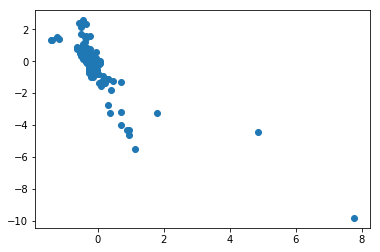

In [19]:
import matplotlib.pyplot as plt
#XZ
plt.scatter(points[:,0], points[:,2])
plt.show()


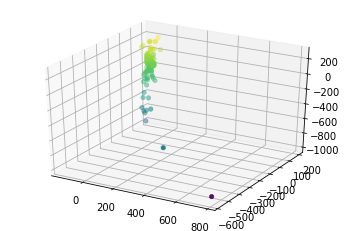

In [20]:
from mpl_toolkits import mplot3d
ax = plt.axes(projection='3d')
scale = 100
ax.scatter(scale * points[:,0], scale * points[:,1], scale * points[:,2], c=points[:,2], cmap='viridis', linewidth=0.5);

In [21]:
# def sift_feature(image, device = 'cuda' if torch.cuda.is_available() else 'cpu'):
#     print("image shape:",image.shape, )
#     h,w = image.shape
#     patch_size = min([h,w])
#     patch = image[:patch_size, :patch_size]#image[h//4: h//4 + patch_size,w//3 : w//3 + patch_size]
#     # It takes n_patches x 1 x patch_size x patch_size input == standard pytorch batch format
#     patches = np.ndarray((1, 1, patch_size, patch_size), dtype=np.float32)
#     patches[0,0,:,:] = patch
        
#     SIFT = SIFTNet(patch_size = patch_size).to(device)
#     SIFT.eval()
    
#     t = time.time()
#     with torch.no_grad():       
#         torch_patches = torch.from_numpy(patches).cuda()
#         res = SIFT(torch_patches)
#         print(res)
#         sift = np.round(512. * res.data.cpu().numpy()).astype(np.int32)

#     print ('device:',device)
#     print(' time', time.time() - t)   
#     plt.figure()
#     plt.imshow(patch, cmap="gray")
#     return sift

In [1]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from tqdm import tqdm
import cv2
import glob, os
from mpl_toolkits import mplot3d

from Normalized8pointsAlgo import RANSAC
from CameraConfig import *
from Triangulation import *


def drawlines(img1,img2,lines,pts1,pts2):
    ''' img1 - image on which we draw the epilines for the points in img2
        lines - corresponding epilines '''
    (r,c,_) = img1.shape
    for r,pt1,pt2 in zip(lines,pts1,pts2):
        color = tuple(np.random.randint(0,255,3).tolist())
        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
        img1 = cv2.line(img1, (x0,y0), (x1,y1), color,1)
        img1 = cv2.circle(img1,tuple(pt1),5,color,-1)
        img2 = cv2.circle(img2,tuple(pt2),5,color,-1)
    return img1,img2


def TwoImage(img1, img2, des1, kp1, des2, kp2, pre_C, pre_R):
    
    # create BFMatcher object
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

    # Match descriptors.
    matches = bf.match(des1,des2)

    # Sort them in the order of their distance.
    matches = sorted(matches, key = lambda x:x.distance)

    trainPoints = cv2.KeyPoint_convert([kp1[matches[i].trainIdx] for i in range(len(matches))])
    queryPoints = cv2.KeyPoint_convert([kp2[matches[i].queryIdx] for i in range(len(matches))])
    pts1 = np.int32(trainPoints)
    pts2 = np.int32(queryPoints)
    
    my_F, train_inliers, query_inliers, ind = RANSAC(pts1, pts2, max_iter_times = 10000) 
    my_F, mask = cv2.findFundamentalMat(trainPoints,queryPoints,cv2.FM_LMEDS)
    # Find epilines corresponding to points in right image (second image) and
    # drawing its lines on left image
    lines1 = cv2.computeCorrespondEpilines(query_inliers.reshape(-1,1,2), 2, my_F)
    lines1 = lines1.reshape(-1,3)
    left_img_with_lines, _ = drawlines(img1.copy(),img2.copy(),lines1,train_inliers,query_inliers)
    # Find epilines corresponding to points in left image (first image) and
    # drawing its lines on right image
    lines2 = cv2.computeCorrespondEpilines(train_inliers.reshape(-1,1,2), 1, my_F)
    lines2 = lines2.reshape(-1,3)
    right_img_with_lines, _ = drawlines(img2.copy(),img1.copy(),lines2,query_inliers,train_inliers)

    

    E = getEssentialMatrix(my_F)
    U, D, Vh = getEssentialConfig(E)

    #second camera
    #C, R are relative to pre camera at [0,0,0]
    C1, R1 = CameraPosition1Config(U, D, Vh)
    C2, R2 = CameraPosition2Config(U, D, Vh)
    C3, R3 = CameraPosition3Config(U, D, Vh)
    C4, R4 = CameraPosition4Config(U, D, Vh)
    
    Cs = [C1,C2,C3,C4]
    Rs = [R1,R2,R3,R4]
    
    #relative to previous camera at exactly position
    for C, R in zip(Cs, Rs):
        R = R @ pre_R.transpose()
        C += -R @ pre_C 
        
    best_ct = 0
    best_secondCamera_C = None
    best_secondCamera_R = None
    points = None

    for C,R in zip(Cs, Rs):
        P1, P2 = getCameraMatrix(K, pre_R, pre_C, R, C) 
        temp_points = getWorldPoints(train_inliers, query_inliers, P1, P2)
        n_in_front_of_C1, n_in_front_of_C2 = CheckCheirality(temp_points, C1, R1, C2, R2)
        if(n_in_front_of_C1 + n_in_front_of_C2 > best_ct):
            best_ct = n_in_front_of_C1 + n_in_front_of_C2
            best_secondCamera_C = C
            best_secondCamera_R = R
            points = temp_points
    #print("max points in front of both cameras:", best_ct)
    print("len(points):",len(points))
##########draw############    
#     #XZ
#     plt.scatter(points[:,0], points[:,2])
#     plt.scatter(pre_C[0], pre_C[2], c='red')
#     plt.scatter(best_secondCamera_C[0], best_secondCamera_C[2], c='black')
#     plt.show()
#     ax = plt.axes(projection='3d')
    
#     ax.scatter(points[:,0], points[:,1], points[:,2], c=points[:,2], cmap='viridis', linewidth=0.5);
#     ax.scatter(pre_C[0], pre_C[1], pre_C[2], c='red', linewidth=15);
#     ax.scatter(best_secondCamera_C[0], best_secondCamera_C[1], best_secondCamera_C[2], c='black', linewidth=15);
#     plt.show()
#########################    
    return [left_img_with_lines, right_img_with_lines],best_secondCamera_C, best_secondCamera_R, K.astype(np.float64), train_inliers.astype(np.float64), query_inliers.astype(np.float64), points.astype(np.float64)
    
if __name__== "__main__":
    files = []
    for file in glob.glob("*.bmp"):        
        files.append(file)
    files.sort()
    print(files)
    imgs = []
    
    for file in files:
        img = cv2.imread(file)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        imgs.append(img)
        
    camera_params = []
    camera_indices = []
    points_3d = []
    points_2d = []
 
    C = {}
    R = {}
    pre_img = None
    pre_kp = None
    pre_des = None
    dist_coef = np.zeros((4,1))
    
    lines_imgs = []
    
    for img_ct, img in tqdm(enumerate(imgs)):
        print(img_ct)
        if(img_ct == 0):
            orb = cv2.ORB_create(edgeThreshold=3)
            pre_img = img
            pre_kp, pre_des = orb.detectAndCompute(pre_img,None)
            #first camera
            pre_C = np.array([0,0,0], dtype=np.float64)
            pre_R = np.array([[1,0,0],[0,1,0],[0,0,1]], dtype=np.float64)
            C[img_ct] = pre_C
            R[img_ct] = pre_R
            continue;
        else:
            #Oriented FAST and Rotated BRIEF
            orb = cv2.ORB_create(edgeThreshold=3)

            # find the keypoints with ORB
            kp, des = orb.detectAndCompute(img,None)
            
            lines_img, outC, outR, K, train_inliers, query_inliers, points3D = TwoImage(imgs[img_ct-1], img, pre_des, pre_kp, des, kp, C[img_ct-1] ,R[img_ct-1])
            lines_imgs.append(lines_img)
            #the first image hasn't been count
            if(img_ct == 1):
                #add the first image rvec and tvec
                #(_, rvec, tvec, _) = cv2.solvePnPRansac(points3D[:,0:3], train_inliers, K, dist_coef, cv2.SOLVEPNP_EPNP)            
                tvec = C[0]
                rvec, jacobian = cv2.Rodrigues(R[0])
                print(tvec)
                print(rvec)
                camera_params.append([rvec[0][0], rvec[1][0], rvec[2][0], tvec[0], tvec[1], tvec[2], f1, 0, 0])
                for i in range(len(points3D)):
                    points_3d.append([points3D[i,0], points3D[i,1], points3D[i,2]])
                    camera_indices.append(0)
                for i in range(len(train_inliers)):
                     points_2d.append(train_inliers[i]) 
            
            tvec = outC
            rvec, jacobian = cv2.Rodrigues(outR)
            #(_, rvec, tvec, _) = cv2.solvePnPRansac(points3D[:,0:3], query_inliers, K, dist_coef, cv2.SOLVEPNP_EPNP)
            camera_params.append([rvec[0][0], rvec[1][0], rvec[2][0], tvec[0], tvec[1], tvec[2], f1, 0, 0])
            for i in range(len(points3D)):
                points_3d.append([points3D[i,0], points3D[i,1], points3D[i,2]])
                camera_indices.append(img_ct)              
            for i in range(len(query_inliers)):
                points_2d.append(query_inliers[i])    
            
            pre_img = img
            pre_kp = kp
            pre_des = des
            C[img_ct] = outC
            R[img_ct] = outR
            
    
    #table = []
    
#     for img1_ct,img1 in enumerate(files):
#         for i 2_ct,img2 in enumerate(files):
#             if img1 != img2 and img1_ct < img2_ct:
#                 print(img1_ct, img2_ct, img1, img2)
#                 dist_coef = np.zeros((4,1))
#                 outC, outR, K, train_inliers, query_inliers, points3D = TwoImage(img1,img2, C[img1_ct], R[img1_ct])
#                 if img1_ct == 0:
#                     C[img2_ct] = outC
#                     R[img2_ct] = outR
#                 print(len(train_inliers))
#                 print(len(points3D))
#                 try:
#                     (_, rvec, tvec, _) = cv2.solvePnPRansac(points3D[:,0:3], train_inliers, K, dist_coef, cv2.SOLVEPNP_EPNP)
#                 except:
#                     if(img1_ct==0):
#                         raise
#                     else:
#                         continue
#                 camera_params.append([rvec[0].item(), rvec[1].item(), rvec[2].item(), tvec[0].item(), tvec[1].item(), tvec[2].item(), f1, 0, 0])
#                 for i in range(len(points3D)):
#                     points_3d.append([points3D[i,0], points3D[i,1], points3D[i,2]])
#                     camera_indices.append(img1_ct)
                    
#                 for i in range(len(train_inliers)):
#                     points_2d.append(train_inliers[i]) 
                
                
#                 try:
#                     (_, rvec, tvec, _) = cv2.solvePnPRansac(points3D[:,0:3], query_inliers, K, dist_coef, cv2.SOLVEPNP_EPNP)
#                 except:
#                     continue
#                 camera_params.append([rvec[0].item(), rvec[1].item(), rvec[2].item(), tvec[0].item(), tvec[1].item(), tvec[2].item(), f1, 0, 0])
#                 for i in range(len(points3D)):
#                     points_3d.append([points3D[i,0], points3D[i,1], points3D[i,2]])
#                     camera_indices.append(img2_ct)
#                 for i in range(len(query_inliers)):
#                     points_2d.append(query_inliers[i])
                
#                 #table.append({str(img1_ct)+"to"+str(img2_ct):[rvec,tvec]})
#                 #solvePnP(InputArray objectPoints, InputArray imagePoints, InputArray cameraMatrix, InputArray distCoeffs, OutputArray rvec, OutputArray tvec, bool useExtrinsicGuess=false, int flags=ITERATIVE )¶

image0000001.bmp
image0000002.bmp
image0000003.bmp
image0000006.bmp
image0000004.bmp
image0000005.bmp


0it [00:00, ?it/s]

0


1it [00:00,  3.93it/s]

1
WARNING(normalise2dpts): Some points are at infinity
WARNING(normalise2dpts): Some points are at infinity
[RANSAC] takes  0.04974818229675293 sec
[RANSAC] iteration 8  err: 0.0007550778831010683


2it [00:02,  1.23it/s]

len(points): 178
[0. 0. 0.]
[[0.]
 [0.]
 [0.]]
2
WARNING(normalise2dpts): Some points are at infinity
WARNING(normalise2dpts): Some points are at infinity
[RANSAC] takes  0.00966501235961914 sec
[RANSAC] iteration 9  err: 0.0854265526932801


3it [00:06,  1.85s/it]

len(points): 200
3
WARNING(normalise2dpts): Some points are at infinity
WARNING(normalise2dpts): Some points are at infinity
[RANSAC] takes  0.042593955993652344 sec
[RANSAC] iteration 39  err: 0.01783203180783996


4it [00:09,  2.12s/it]

len(points): 198
4
WARNING(normalise2dpts): Some points are at infinity
WARNING(normalise2dpts): Some points are at infinity
[RANSAC] takes  0.014256954193115234 sec
[RANSAC] iteration 10  err: 0.023906689919691627


5it [00:11,  2.17s/it]

len(points): 209
5
WARNING(normalise2dpts): Some points are at infinity
WARNING(normalise2dpts): Some points are at infinity
[RANSAC] takes  0.014026165008544922 sec
[RANSAC] iteration 21  err: 0.009972035092998035


6it [00:13,  2.10s/it]

len(points): 190


In [3]:
print(points_3d[:10])

[[0.005882754999215806, 0.042735927959758495, 0.7262118639726535], [-0.29737385267317673, -0.0026320656806208547, 1.0005974191966713], [0.23972002770493264, 0.28525741329981275, 0.36270556501316276], [0.17876772371297608, 0.22547655743580064, 0.3846834861779375], [-0.5193602332807133, -0.2770525600465636, 1.4123891966193736], [0.1639623573641429, 0.29223159349400346, 0.6757053108311784], [0.16186740430392965, 0.2721444637409534, 0.765457200451578], [0.08411549301391684, -0.7822762123807526, 1.3329324608486297], [0.07232312744155324, 0.340397909352572, 0.2238044665119999], [0.18657058652417616, 0.26888859587782854, 0.6021845256837013]]


1153
n_cameras: 6
n_points: 1153
Total number of parameters: 3513
Total number of residuals: 2306
[  0.           0.           0.           0.           0.
   0.         568.99614085   0.           0.        ]
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.2772e+10                                    3.91e+20    
       1              3         1.3213e+10      9.56e+09       7.96e+01       8.19e+19    
       2              5         1.0395e+10      2.82e+09       4.46e+01       4.25e+19    
       3              7         9.2497e+09      1.15e+09       2.69e+01       3.10e+19    
       4              8         7.3508e+09      1.90e+09       5.13e+01       1.70e+19    
       5             10         6.5637e+09      7.87e+08       1.97e+01       1.27e+19    
       6             11         5.2405e+09      1.32e+09       3.72e+01       7.13e+18    
       7             13         4.6833e+09      5.57e+08      

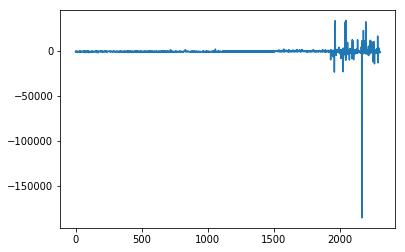

In [4]:
from BundleAdjustment import *
from scipy.optimize import least_squares
import time
camera_params = np.array(camera_params)
camera_indices = np.array(camera_indices)
print(len(points_3d))
point_indices = np.array(range(len(points_3d)))
points_3d = np.array(points_3d)
points_2d = np.array(points_2d)
n_cameras = camera_params.shape[0]
n_points = points_3d.shape[0]

n = 9 * n_cameras + 3 * n_points
m = 2 * points_2d.shape[0]

print("n_cameras: {}".format(n_cameras))
print("n_points: {}".format(n_points))
print("Total number of parameters: {}".format(n))
print("Total number of residuals: {}".format(m))
print(camera_params[0])
x0 = np.hstack((camera_params.ravel(), points_3d.ravel()))

f0 = fun(x0, n_cameras, n_points, camera_indices, point_indices, points_2d)
plt.plot(f0)
A = bundle_adjustment_sparsity(n_cameras, n_points, camera_indices, point_indices)
t0 = time.time()
res = least_squares(fun, x0, jac_sparsity=A, verbose=2, x_scale='jac', ftol=1e-4, method='trf',
                args=(n_cameras, n_points, camera_indices, point_indices, points_2d))
t1 = time.time()
print("Optimization took {0:.0f} seconds".format(t1 - t0))
#plt.plot(res.fun)
#fun(params, n_cameras, n_points, camera_indices, point_indices, points_2d)

In [5]:
print(res)

 active_mask: array([0., 0., 0., ..., 0., 0., 0.])
        cost: 10362996.662470467
         fun: array([-1.05326117e-05, -6.22402689e-06, -1.17979580e-05, ...,
       -3.02966482e+01, -9.46484009e+02, -6.65262710e+02])
        grad: array([-8.29763555e-01,  4.18700731e+00, -5.24098405e-01, ...,
        5.82540650e+03,  1.44121556e+04, -6.08376882e+03])
         jac: <2306x3513 sparse matrix of type '<class 'numpy.float64'>'
	with 27672 stored elements in Compressed Sparse Row format>
     message: '`ftol` termination condition is satisfied.'
        nfev: 90
        njev: 66
  optimality: 9720278787584698.0
      status: 2
     success: True
           x: array([ 0.12743747, -0.27527288,  0.34558809, ..., -0.61523965,
        0.89474377,  1.41190037])


In [8]:
camera_params = res.x[:n_cameras * 9].reshape((n_cameras, 9))
points_3d = res.x[n_cameras * 9:].reshape((n_points, 3))
print(len(points_3d))

1153


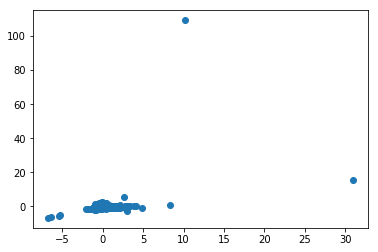

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

0
1
2
3
4
5


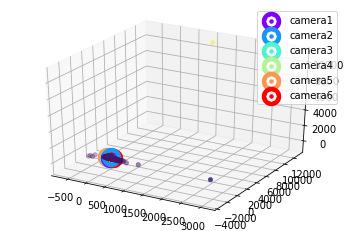

In [7]:
import matplotlib.cm as cm
#XZ
plt.scatter(points_3d[:,0], points_3d[:,2])
#plt.scatter(C0[0], C0[2], c='red')
#plt.scatter(C1[0], C1[2], c='black')
plt.show()
scale = 100
ax = plt.axes(projection='3d')
ax.scatter(scale * points_3d[:,0], scale * points_3d[:,1], scale * points_3d[:,2], c=points_3d[:,2], cmap='viridis', linewidth=0.5);
colors = cm.rainbow(np.linspace(0, 1, len(C)))

for i,c in zip(C,colors):
    print(i)
    ax.scatter(scale * C[i][0], scale * C[i][1], scale * C[i][2], c=c, linewidth=15, label='camera'+str(i+1));
ax.legend()
plt.show()

In [ ]:
plt.figure(figsize=(10, 20))
for i, (left, right) in enumerate(lines_imgs):
    plt.subplot(len(lines_imgs*2),2,2*i+1)
    plt.imshow(left)
    plt.subplot(len(lines_imgs*2),2,2*i+2)
    plt.imshow(right)

In [ ]:
print(len(points_3d))

In [ ]:
print(points_3d[:10])